## 1. Imports

In [ ]:
!pip install nlp
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import re
import pandas as pd
import nlp
import spacy
import string
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
import tensorflow_hub as hub
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
directory = '/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/Ten Documents'

## 2. Pre-process Text

In [ ]:
def get_text_from_txt(filename):
  with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()
    f.close()
  return text

In [ ]:
def clean_text(text):
  # removing new line characters
  text = re.sub('\n', '', text)
  text = re.sub('\n', ' ', text)
  # remove apostrophes
  text = re.sub("'s", '', text)
  # replacing hyphen with blank space
  text = re.sub('-', ' ', text)
  text = re.sub('- ', '', text)
  # remove quotation marks
  text = re.sub('\"', '', text)
  # remove whitespaces
  text = text.strip()
  return text

In [ ]:
# read documents and create dataframe with text

df = pd.DataFrame(columns=['filename', 'review'])
i = 0
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        df.loc[i, 'filename'] = filename
        text = get_text_from_txt(filepath)
        df.loc[i, 'review'] = text
        i += 1

In [ ]:
df.shape

(10, 2)

In [ ]:
df.head()

,filename,review
0,doc1.txt,Source: www.goodreads.com \nList: Best Books o...
1,doc2.txt,Source: www.goodreads.com \nList: Best Books o...
2,doc3.txt,Source: www.goodreads.com \nList: Best Books o...
3,doc4.txt,Source: www.goodreads.com \nList: Best Books o...
4,doc5.txt,Source: www.goodreads.com \nList: Best Books o...


In [ ]:
df['clean_review'] = df['review'].apply(clean_text)

In [ ]:
df.head()

,filename,review,clean_review
0,doc1.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...
1,doc2.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...
2,doc3.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...
3,doc4.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...
4,doc5.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...


In [ ]:
# Function to split sentences and exclude website names
def sentences(text):
    if not isinstance(text, str):
        return []

    # Replace URLs with placeholders
    url_pattern = re.compile(r'http\S+|www\.\S+')
    urls = url_pattern.findall(text)
    for i, url in enumerate(urls):
        text = text.replace(url, f'URL_PLACEHOLDER_{i}')

    # Split sentences and questions
    text = re.split(r'(?<!URL_PLACEHOLDER_\d)[.?!]', text)
    clean_sent = []
    for sent in text:
        if sent.strip():  # check if the sentence is not just whitespace
            clean_sent.append(sent.strip())

    # Restore URLs from placeholders
    for i, url in enumerate(urls):
        clean_sent = [sent.replace(f'URL_PLACEHOLDER_{i}', url) for sent in clean_sent]

    return clean_sent

In [ ]:
# create a new column to store clean sentences
df['sentences'] = df['clean_review'].apply(sentences)

In [ ]:
df.head()

,filename,review,clean_review,sentences
0,doc1.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...,[Source: www.goodreads.com List: Best Books of...
1,doc2.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...,[Source: www.goodreads.com List: Best Books of...
2,doc3.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...,[Source: www.goodreads.com List: Best Books of...
3,doc4.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...,[Source: www.goodreads.com List: Best Books of...
4,doc5.txt,Source: www.goodreads.com \nList: Best Books o...,Source: www.goodreads.com List: Best Books of ...,[Source: www.goodreads.com List: Best Books of...


#### **Not removing stop words and not lemmatizing tokens** preserves the full context and syntactical structure of the text, which is crucial for models like Word2Vec, Doc2Vec, and ELMo that rely on context for generating meaningful embeddings. Stop words help maintain grammatical relationships, while original word forms convey nuances lost through lemmatization. This approach ensures better performance in downstream tasks like sentiment analysis and document classification, providing richer, more interpretable embeddings. Additionally, it allows for consistent evaluation across different embedding methods, enhancing comparability and overall understanding.

In [ ]:
df['sentences'][0]

['Source: www.goodreads.com List: Best Books of the 20th CenturyTitle: To Kill a MockingbirdAuthor: Harper LeeRanking in the List: 1Rating: 4',
 '26Genres: Classics, Fiction, Historical Fiction, School, Literature, Young Adult, Historical, Novels, High SchoolTotal Word Count: 538Key Words: bestseller, town, kill, mockingbird, price, love, human, hate, Alabama, kindness, copies, masterpiece, literature, publish, enjoy',
 'Brief Summary: The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it',
 'To Kill A Mockingbird became both an instant bestseller and a critical success when it was first published in 1960',
 'It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award winning film, also a classic',
 'Compassionate, dramatic, and deeply moving, To Kill A Mockingbird takes readers to the roots of human behavior   to innocence and experience, kindness and cruelty, love and hatred, humor and pathos',
 'Now wit

## 3. Word2Vec

In [ ]:
# Tokenize sentences into words
comprehensive_list = df['sentences'].tolist()
sentences = [sentence for sublist in comprehensive_list for sentence in sublist]
tokenized_sentences = [sentence.split() for sentence in sentences]

# Flatten the list of tokenized sentences to get all words
all_words = [word for sentence in tokenized_sentences for word in sentence]

# Count the frequency of each word
word_counts = Counter(all_words)

# top ten TF-IDF words
top_ten_tf_idf = ['novel', 'author', 'fiction', 'story', 'romance', 'love', 'write', 'book', 'historical', 'words']

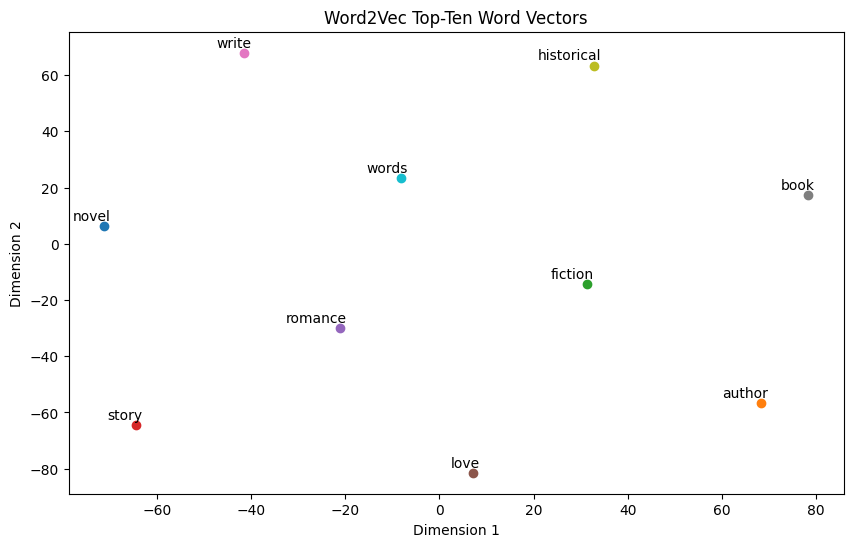

In [ ]:
# Train a Word2Vec model
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the model
model.save("word2vec.model")

# Extract vectors for the top ten TF-IDF words that are in the model's vocabulary
word_vectors = []
valid_words = []
for term in top_ten_tf_idf:
    if term in model.wv:
        word_vectors.append(model.wv[term])
        valid_words.append(term)
    else:
        print(f"Word '{term}' not in vocabulary.")

# Convert word vectors to a NumPy array
word_vectors = np.array(word_vectors)

# Use t-SNE to reduce the dimensionality of the word vectors to 2D
perplexity_value = min(len(valid_words) - 1, 30)  # Ensure perplexity is less than the number of samples
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the vectors
plt.figure(figsize=(10, 6))
for i, word in enumerate(valid_words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title('Word2Vec Top-Ten Word Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

## 4. Doc2Vec

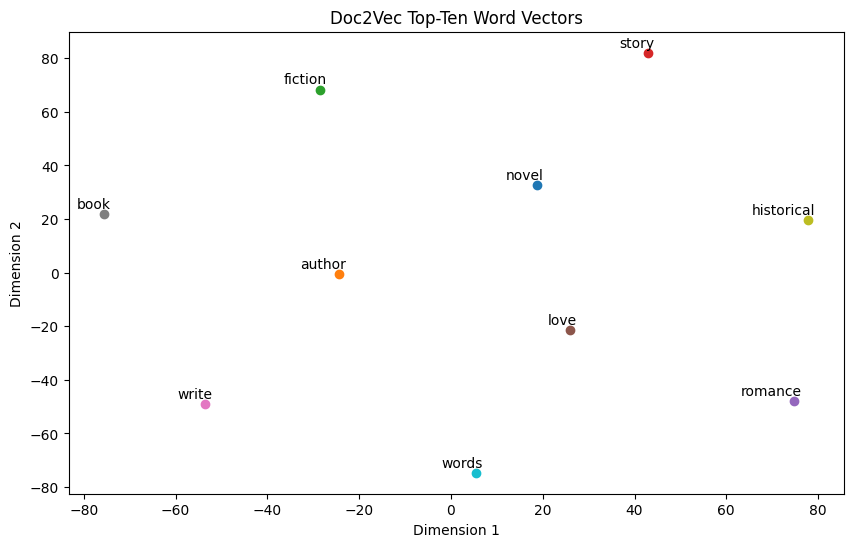

In [ ]:
# Tagging the documents
tagged_data = [TaggedDocument(words=review.split(), tags=[str(i)]) for i, review in enumerate(df.clean_review)]

# Train a Doc2Vec model with min_count=1 to include all words
model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

# Save the model
model.save("doc2vec.model")

# Extract vectors for the top ten TF-IDF words that are in the model's vocabulary
word_vectors = []
valid_words = []
for term in top_ten_tf_idf:
    if term in model.wv:
        word_vectors.append(model.wv[term])
        valid_words.append(term)
    else:
        print(f"Word '{term}' not in vocabulary.")

# Convert word vectors to a NumPy array
word_vectors = np.array(word_vectors)

# Use t-SNE to reduce the dimensionality of the word vectors to 2D
perplexity_value = min(len(valid_words) - 1, 30)  # Ensure perplexity is less than the number of samples
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the vectors
plt.figure(figsize=(10, 6))
for i, word in enumerate(valid_words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title('Doc2Vec Top-Ten Word Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


##5. ELMo

Model vocabulary size: 1650
Number of valid words: 1650


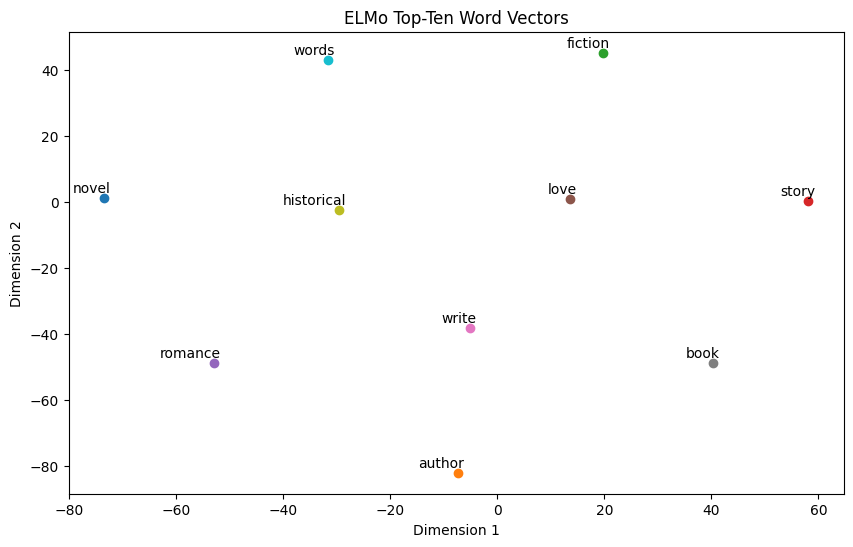

In [ ]:
# Load the ELMo model from TensorFlow Hub
elmo = hub.load("https://tfhub.dev/google/elmo/3")

# Function to compute ELMo embeddings
def elmo_embedding(x):
    return elmo.signatures['default'](tf.constant(x))['elmo']

# df.sentences contains the sentences
comprehensive_list = df['sentences'].tolist()
sentences = [sentence for sublist in comprehensive_list for sentence in sublist]

# Vectorize the text
vectorizer = TfidfVectorizer(max_features=2500)
X = vectorizer.fit_transform(sentences)

# Get the feature names (words)
vocab = vectorizer.get_feature_names_out()

# Print the model vocabulary size
print("Model vocabulary size:", len(vocab))

# Extract ELMo vectors for all words
word_vectors = []
valid_words = []
for term in vocab:
    term_vector = elmo_embedding([term]).numpy()[0][0]
    word_vectors.append(term_vector)
    valid_words.append(term)

# Print the number of valid words
print("Number of valid words:", len(valid_words))

# Filter word vectors to include only the top ten TF-IDF words
filtered_word_vectors = [word_vectors[valid_words.index(word)] for word in top_ten_tf_idf if word in valid_words]
filtered_valid_words = [word for word in top_ten_tf_idf if word in valid_words]

# Convert filtered word vectors to a NumPy array
filtered_word_vectors = np.array(filtered_word_vectors)

# Use t-SNE to reduce the dimensionality of the word vectors to 2D
perplexity_value = min(len(filtered_valid_words) - 1, 30)  # Ensure perplexity is less than the number of samples
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=0)
word_vectors_2d = tsne.fit_transform(filtered_word_vectors)

# Plot the vectors
plt.figure(figsize=(10, 6))
for i, word in enumerate(filtered_valid_words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title('ELMo Top-Ten Word Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
